In [1]:
#conda install missingno

In [2]:
import pandas as pd
import numpy as np
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_null = pd.read_csv('../data/df_clean_nulls.csv', index_col=0)
df_nonull = pd.read_csv('../data/df_clean_nonulls.csv', index_col=0)
df_null.shape, df_nonull.shape

((21287, 14), (21287, 14))

# I. Distribution of Null Values

In [4]:
# Number of NAs in each column

perc_na = round(df_null.isna().sum() * 100 / len(df_null), 2)

df_na = pd.DataFrame({'Total NA':df_null.isna().sum(), 'DType':df_null.dtypes, '% NA':perc_na})
df_na

,Total NA,DType,% NA
enrollee_id,0,int64,0.00
city,0,object,0.00
city_development_index,0,float64,0.00
gender,5016,object,23.56
relevent_experience,0,int64,0.00
enrolled_university,417,object,1.96
education_level,512,object,2.41
major,3125,object,14.68
company_size,6560,object,30.82
company_type,6774,object,31.82


Company size and type seem to have the most missing values, closely followed by gender.

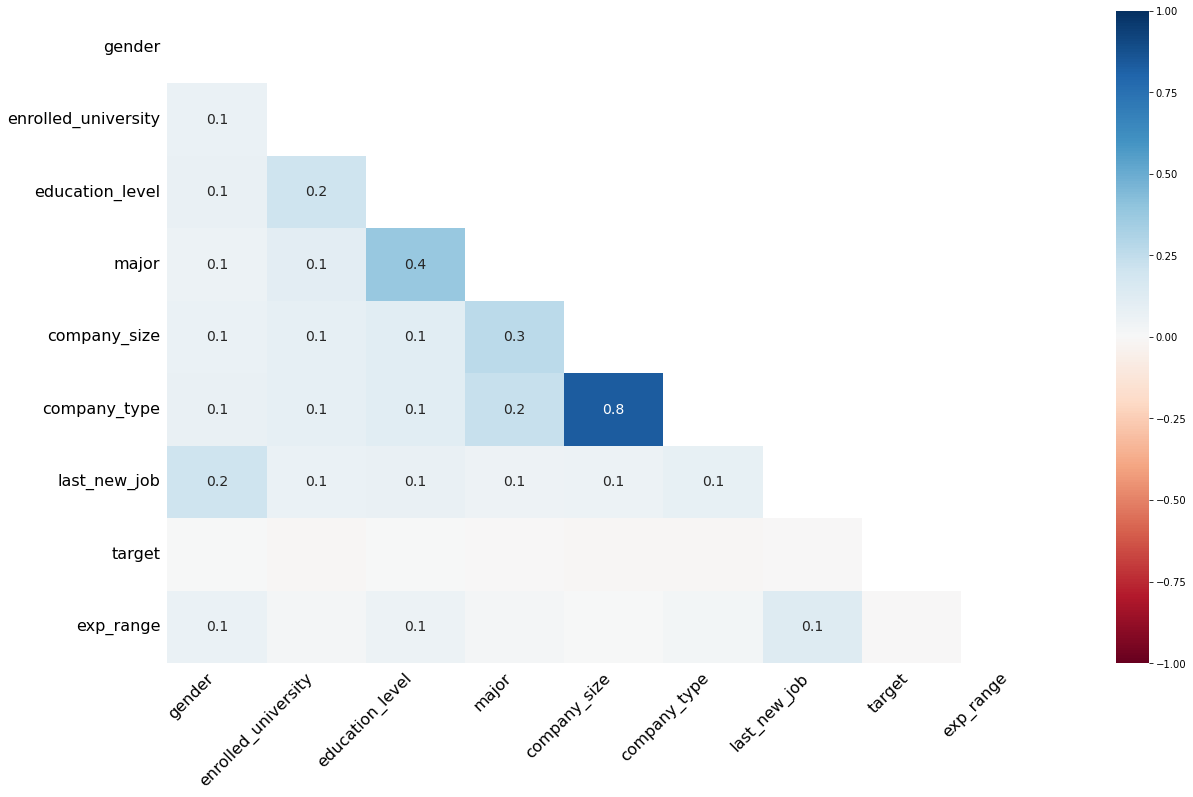

In [5]:
msno.heatmap(df_null);

If company size is filled in, company type most likely is too.

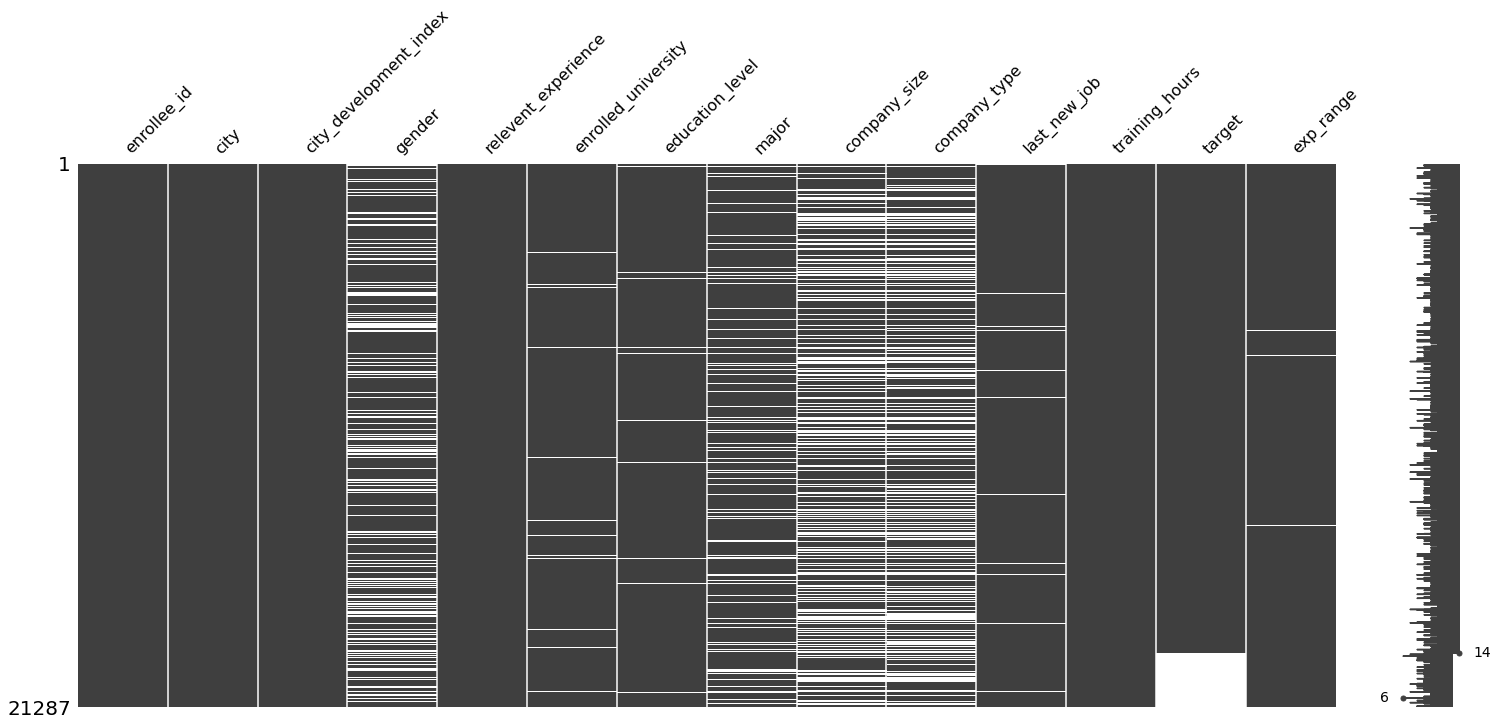

In [6]:
msno.matrix(df_null);

In [7]:
# Number of missing values per row, value counts

row_nulls = df_null.apply(lambda x: x.isna().sum(), axis=1)
row_nulls.value_counts(ascending=False)

0    8955
1    4737
2    4088
3    2329
4     843
5     236
6      81
7      16
8       2
dtype: int64

Two rows have 8 missing values, and sixteen have 7 missing values. It might be useful to drop these.

In [8]:
mask = df_null.apply(lambda x: x.isna().sum(), axis=1)>=7
sparse_rows = row_nulls[mask].index.tolist()
sparse_rows

[1376,
 2518,
 7746,
 8905,
 9206,
 10337,
 11789,
 12079,
 12348,
 13236,
 17453,
 17977,
 19211,
 19283,
 20377,
 20680,
 20921,
 21103]

These rows will be dropped from both dfs (nulls and no nulls)

In [9]:
df_null.drop(index=sparse_rows, inplace=True)
df_nonull.drop(index=sparse_rows, inplace=True)

In [10]:
df_null.shape, df_nonull.shape

((21269, 14), (21269, 14))

In [11]:
# Number of NAs in each column

perc_na = round(df_null.isna().sum() * 100 / len(df_null), 2)

df_na = pd.DataFrame({'Total NA':df_null.isna().sum(), 'DType':df_null.dtypes, '% NA':perc_na})
df_na

,Total NA,DType,% NA
enrollee_id,0,int64,0.00
city,0,object,0.00
city_development_index,0,float64,0.00
gender,4998,object,23.50
relevent_experience,0,int64,0.00
enrolled_university,402,object,1.89
education_level,495,object,2.33
major,3107,object,14.61
company_size,6542,object,30.76
company_type,6756,object,31.76


This didn't make much of a dent in terms of percentage of missing values. Perhaps consider also removing rows with 6 missing values?

In [12]:
# Save dfs with rows removed

df_null.to_csv('../data/df_clean_nulls2')
df_nonull.to_csv('../data/df_clean_nulls2')

# II. Relationship Between Variables

In [13]:
df_nonull.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major,company_size,company_type,last_new_job,training_hours,exp_range,target
0,8949,city_103,0.920,Male,1,no_enrollment,Graduate,STEM,MISSING,MISSING,1,36,>20,1.0
1,29725,city_40,0.776,Male,0,no_enrollment,Graduate,STEM,50-99,private_limited,>4,47,11-15,0.0
2,11561,city_21,0.624,MISSING,0,full_time,Graduate,STEM,MISSING,MISSING,never,83,2-5,0.0
3,33241,city_115,0.789,MISSING,0,MISSING,Graduate,Business Degree,MISSING,private_limited,never,52,<=1,1.0
4,666,city_162,0.767,Male,1,no_enrollment,Masters,STEM,50-99,startup_funded,4,8,>20,0.0


In [14]:
df_nonull.shape

(21269, 14)

## a) Numeric Columns

In [15]:
num_cols = ['city_development_index', 'relevent_experience', 'training_hours', 'target']

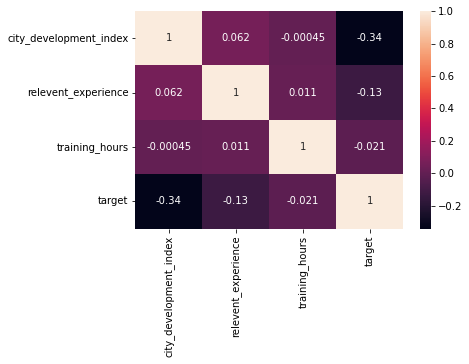

In [16]:
# Make a heatmap

plt.figure()
sns.heatmap(df_nonull[num_cols].corr(), annot=True);

City development index seems to have a fairly strong relationship with the target variable.

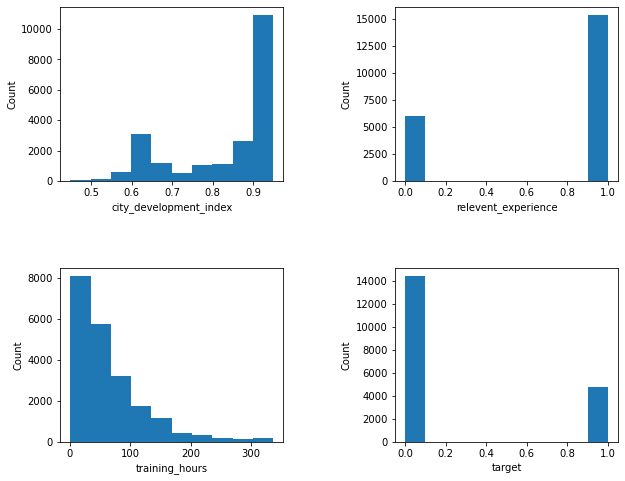

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
for i, col in enumerate(num_cols):
    ax = axes.flatten()[i]
    ax.hist(x=col, data=df_nonull)
    ax.set(xlabel=col, ylabel='Count')

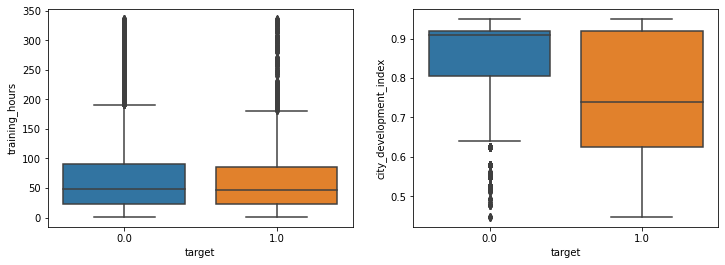

In [18]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(x='target', y='training_hours', data=df_nonull, ax=axes[0]);
sns.boxplot(x='target', y='city_development_index', data=df_nonull, ax=axes[1]);

There isn't much of a relationship between the target and training hours, but it seems that people from the highest CDIs are less likely to be interested in a job change.

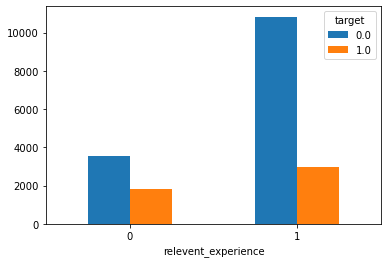

In [19]:
df_plot = df_nonull.groupby(['relevent_experience', 'target']).size().reset_index().pivot(
    columns='target', index='relevent_experience', values=0)
df_plot.plot(kind='bar', rot=0);

People without relevant experience seem more willing to be open to a job change than those with relevant experience.

## b) Categorical Columns

In [20]:
cat_cols = ['gender', 'enrolled_university', 'education_level', 'major', 'company_size',
            'company_type', 'last_new_job', 'exp_range']

In [21]:
# For reindexing ordinal cols

enroll = ['no_enrollment', 'part_time', 'full_time', 'missing']
ed_level = ['Primary School', 'High School', 'Graduate', 'Masters', 'Phd', 'missing']
exp_lv = ['<=1','2-5','6-10','11-15','16-20','>20', 'missing']
comp_sz = ['<10','10-49','50-99','100-499','500-999','1000-4999','5000-9999','10000+', 'missing']
last_job = ['never','1','2','3','4', '>4', 'missing']
job_type = ['private_limited','startup_funded','startup_earlystage','public_sector','NGO','Other','missing']

In [22]:
def target_bar(ax, x, y, df, reindex=None):
    """Plot bar graphs that compare different levels of a
    column to different levels of a target"""
    if reindex:
        df_plot = df.groupby([x, y]).size().reset_index().pivot(columns=y, index=x, values=0).reindex(reindex)
    else:
        df_plot = df.groupby([x, y]).size().reset_index().pivot(columns=y, index=x, values=0)
    df_plot.plot(kind='bar', rot=45, ax=ax)

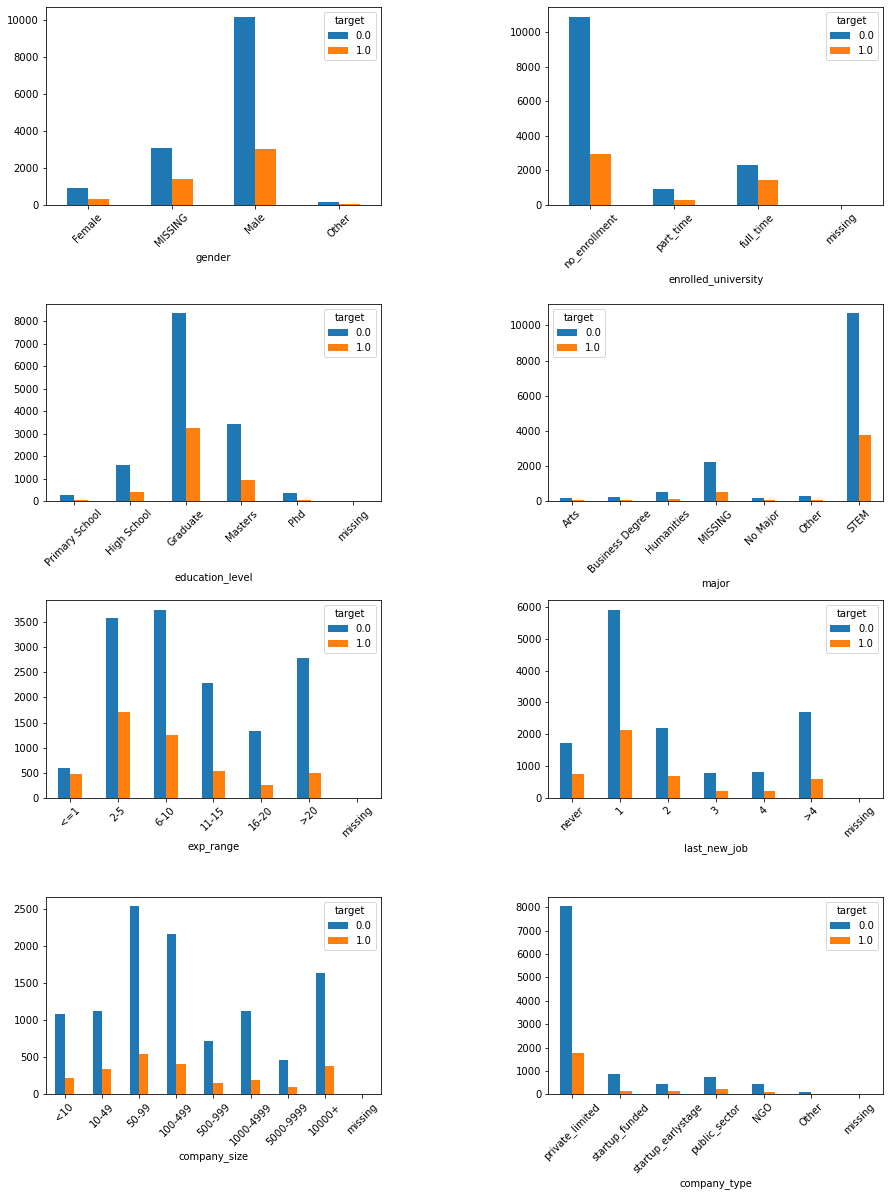

In [23]:
fig, axes = plt.subplots(4,2, figsize=(15,20))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

target_bar(axes[0,0], 'gender', 'target', df_nonull)
target_bar(axes[0,1], 'enrolled_university', 'target', df_nonull, reindex=enroll)
target_bar(axes[1,0], 'education_level', 'target', df_nonull, reindex=ed_level)
target_bar(axes[1,1], 'major', 'target', df_nonull)
target_bar(axes[2,0], 'exp_range', 'target', df_nonull, reindex=exp_lv)
target_bar(axes[2,1], 'last_new_job', 'target', df_nonull, reindex=last_job)
target_bar(axes[3,0], 'company_size', 'target', df_nonull, reindex=comp_sz)
target_bar(axes[3,1], 'company_type', 'target', df_nonull, reindex=job_type)

#### Based on the above barplots, people are more likely to be open to a job change if...
- They identify as female or other.
- They are currently enrolled in university (current student).
- They are not a STEM student.
- They have less work experience.
- They work in the public sector, for an NGO, or (to some degree) a startup.